# Feature Engineering


## Remove Outliers


##### check train and test overlap - to make sure that we are really training on features that are relevant to our test data set


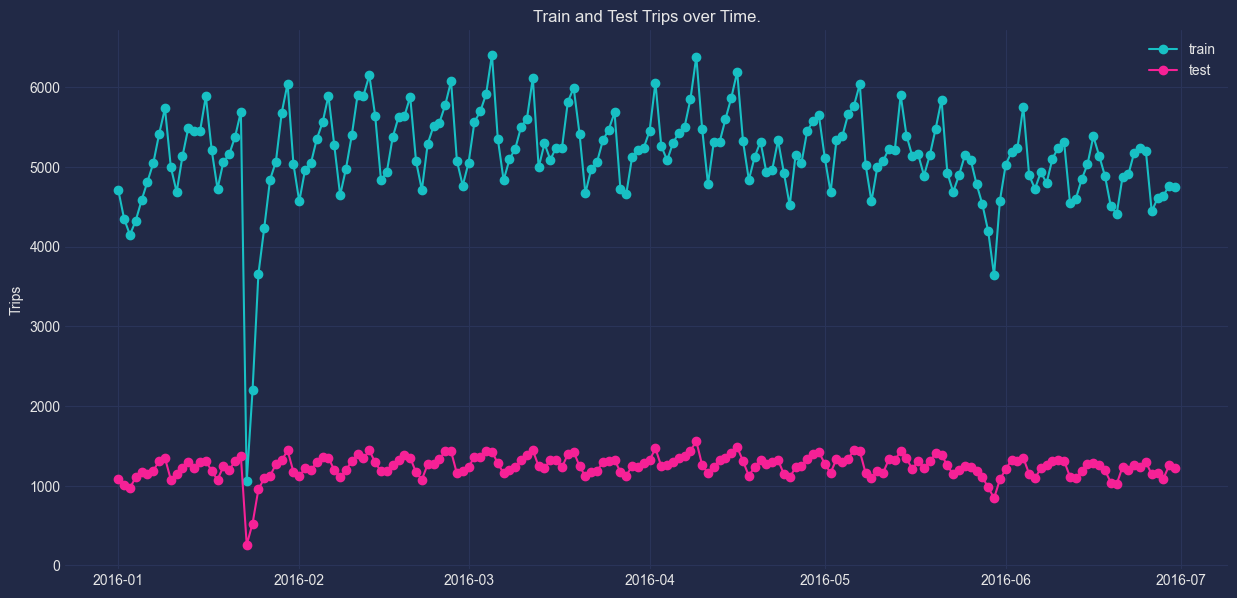

In [ ]:
def check_train_test_overlap(train, test):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
    plt.plot(train.groupby('pickup_date').count()[['vendor_id']], 'o-', label='train')
    plt.plot(test.groupby('pickup_date').count()[['vendor_id']], 'o-', label='test')
    ax1.set_title('Train and Test Trips over Time.')
    ax1.legend(loc=0)
    ax1.set_ylabel('Trips')
    plt.show()

check_train_test_overlap(train, test)

#### passenger_count and vendor_id VS trip_duration

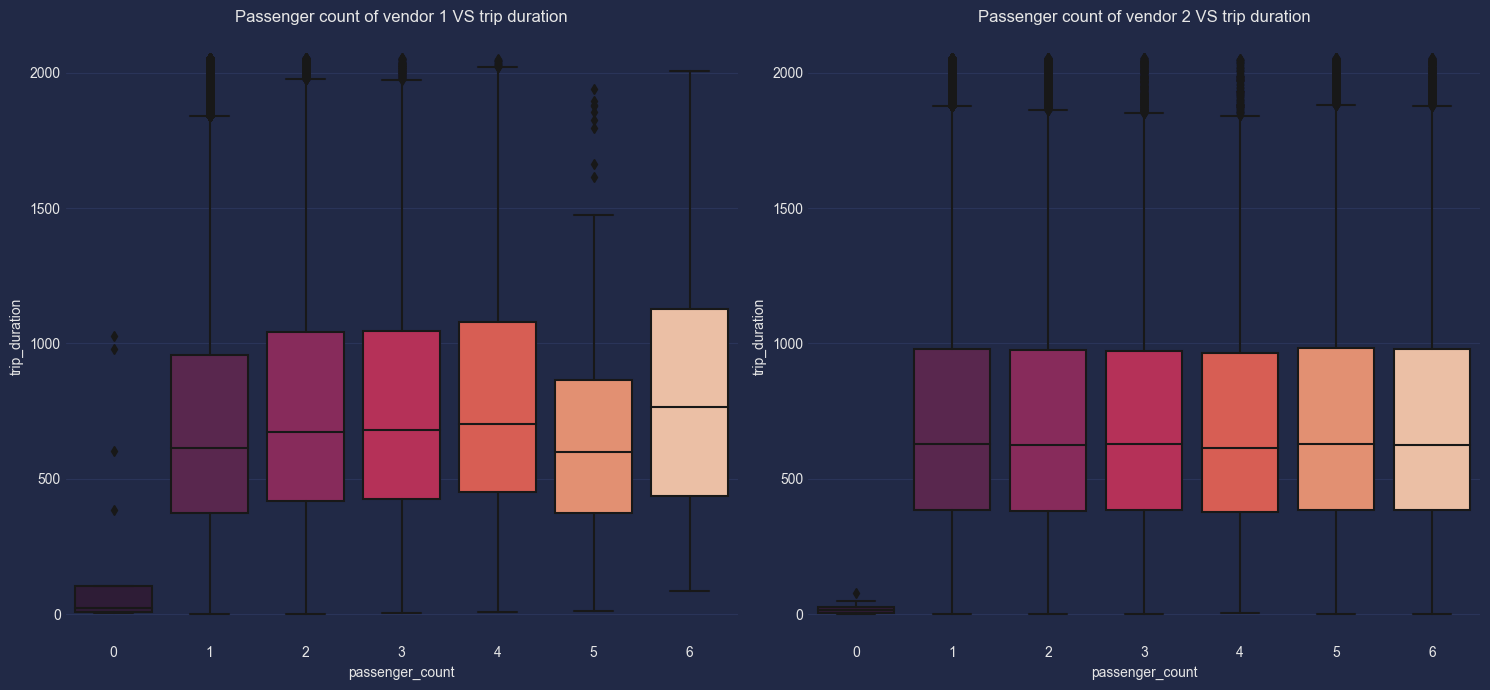

In [ ]:
fig ,ax = plt.subplots(1,2,figsize=(15,7))

box1 = sns.boxplot(data=train[train['vendor_id']==1].reset_index(), x='passenger_count', y='trip_duration',ax=ax[0],palette='rocket')
box2 = sns.boxplot(data=train[train['vendor_id']==2].reset_index(), x='passenger_count', y='trip_duration',ax=ax[1],palette='rocket')
box1.set(title='Passenger count of vendor 1 VS trip duration')
box2.set(title='Passenger count of vendor 2 VS trip duration')
fig.tight_layout()
fig.show()

- With passenger = 0, the trip duration was at max minimum 2.5 min. and maximum 20 min.These are outliers and should be removed.
- Some trips has very short duration ~ 0.5 min. with both vendors.
- When passenger count 2 and 5, vendor 2 has some trips around ~ 340hrs.
- Vendor 1 only carried atmost 6 passengers at a time. Very less trips are there when passenger count is 7,8,9 with vendor 2.

In [ ]:
print('Rows before train:',train.shape[0])
print('Rows before test:',test.shape[0])
train = train[~(train['passenger_count'] == 0)]
test = test[~(test['passenger_count'] == 0)]
print('Rows after train:',train.shape[0])
print('Rows after train:',test.shape[0])

Rows before train: 937099
Rows before test: 226249
Rows after train: 937067
Rows after train: 226237


In [ ]:
train .columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'pickup_cluster_label', 'dropoff_cluster_label', 'trip_distance',
       'pickup_year', 'pickup_month', 'pickup_day', 'weekday', 'is_weekend',
       'pickup_hour', 'season', 'pickup_date', 'is_rush_hour'],
      dtype='object')

In [ ]:
train.drop(columns=['vendor_id','id','pickup_datetime','store_and_fwd_flag','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True, axis=1)

In [ ]:
train.drop(columns=['pickup_day'], inplace=True, axis=1)


In [ ]:
train.drop(columns=['passenger_count'], inplace=True, axis=1)


In [ ]:
train.head()

,trip_duration,pickup_cluster_label,dropoff_cluster_label,trip_distance,pickup_year,pickup_month,weekday,is_weekend,pickup_hour,season,pickup_date,is_rush_hour
0,1040,2,0,2.763050,2016,6,2,0,7,3,2016-06-08,0
1,827,0,0,1.959178,2016,4,6,1,12,2,2016-04-03,0
2,614,0,0,1.404772,2016,6,6,1,2,3,2016-06-05,0
3,867,2,0,1.978660,2016,5,3,0,17,2,2016-05-05,0
5,374,3,3,0.624626,2016,4,3,0,12,2,2016-04-14,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import joblib
import warnings

warnings.filterwarnings('ignore')

# Define feature columns
feature_columns = [
    'pickup_cluster_label', 'dropoff_cluster_label', 'pickup_year', 'pickup_month', 
    'weekday', 'season', 'trip_distance', 'pickup_hour', 
    'is_weekend', 'is_rush_hour'
]

# Select features and target
X = train[feature_columns]
y = train['trip_duration']

# Train-test split for initial validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial features
    ('scaler', StandardScaler()),    # Feature scaling
    ('lasso', Lasso())               # Lasso regression
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [1, 2, 3],        # Degrees of polynomial features
    'lasso__alpha': [0.1, 1.0, 10.0]  # Lasso regularization parameter
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}')

# Evaluate on the test set
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {test_rmse}')



MemoryError: Unable to allocate 32.0 MiB for an array with shape (7, 599723) and data type int64

In [ ]:
# Save the model
joblib.dump(best_model, 'best_lasso_model.pkl')
print("Model saved as 'best_lasso_model.pkl'")


Model saved as 'best_lasso_model.pkl'
